In [1]:
import nltk
from nltk import corpus
from nltk.collocations import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import wordnet
from nltk import punkt
from nltk.util import ngrams
from nltk import FreqDist
#if these last 2 don't work might need to do nltk.download(package)
import re
from bs4 import BeautifulSoup
import unicodedata

from string import punctuation
from collections import Counter
import numpy as np

In [2]:
import gensim
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities.docsim import MatrixSimilarity
from six import iteritems

import pandas as pd
from datetime import datetime

#Importing sklearn for bigram finder
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#import mpld3
#from mpld3 import plugins
#mpld3.enable_notebook()

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as offline


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# allow plots to appear in the notebook
%matplotlib inline


## Import and Clean Connect Report

In [4]:
report=pd.read_csv('connect_report.csv')

report['Created Date']=pd.to_datetime(report['Created Date'])
report=report[pd.notnull(report['Created Date'])]
report=report[pd.notnull(report['Body'])]

#Removing HTML tags and codes
report['Body'] = report['Body'].apply(lambda x:BeautifulSoup(x))
report['Body'] = report['Body'].apply(lambda x:x.get_text())

#Removing tags/mentions
report['Body'] = report['Body'].apply(lambda x:re.sub('{@[\w\d]*}', '',x))

#Removing urls
report['Body'] = report['Body'].apply(lambda x:re.sub(r'^https?:\/\/.*[\r\n]*', '', x,flags=re.MULTILINE))

#Removing weird unicode characters
report['Body'] = report['Body'].apply(lambda x: x.encode('ascii', 'ignore'))

C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\site-packages\bs4\__init__.py:181: UserWarning:

No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file C:\Users\577931\AppData\Local\Continuum\anaconda2\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")




## Report Generator

In [5]:
final_report=pd.DataFrame

#Use this function to create the final report
# Directions:
# 1. Set Group to a list of group names, a single name of a group, or All to use all groups
# 2. Set Type to a specific Feed Item Type or All
# 3. Set Start Date or leave blank(defaults to: )
# 4. Set End Date or leave blank(defaults to: )

def report_generator(Group,Type,Date_start=pd.to_datetime("2017-01-01"),Date_finish=pd.to_datetime('today')):
    if type(Group) == list:
        final_report=report.loc[report['Name'].isin(Group)] 
    elif (Group=='All'):
        final_report=report
    else:
        final_report=report.loc[report['Name']==Group]
                                
    if (Type=='All'):
        final_report=final_report
    else:
        final_report=final_report.loc[final_report['Feed Item Type']==Type]
    
    if(Date_start=="2017-01-01" and Date_finish== pd.to_datetime('today')):
        final_report=final_report
    else:
        Date_start=pd.to_datetime(Date_start, utc=False)
        Date_finish=pd.to_datetime(Date_finish, utc=False)
        #alt approach-- not working but not sure why-- it worked it worked it worked! had to change the data type to all be annoying ass datatime64... down the line that might be a pain but for now it's dope
        final_report=final_report[(final_report['Created Date'] > Date_start) & (final_report['Created Date']< Date_finish)]   
    return(final_report)

final_report=report_generator(['CPC+ All','NLT Internal Users'],'All',"2017-02-01","2017-04-01")

final_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post


## Tokenizer Function

In [6]:
##Stop word and lemmatizer creation (PLEASE add to stop where you see fit)
stop = stopwords.words('english')
stop.append("cpc+")
stop.append("hi")
stop.append("hello")
stop.append("also")
stop.append("anyone")
stop.append("et")
stop.append("please")

wnl = WordNetLemmatizer() 

In [7]:
#this function tokenizes text, removes stop word and punctuation, and lemmatizes the tokens
def tokenizer(text):
 
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text.lower())]
    
    tokens = []
    
    for token_by_sent in tokens_:
        tokens += token_by_sent
 
    tokens = list(filter(lambda t: t not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"'s", u"n't",u"'ve",u"'re",u"'d",u"'ll",u"'m", u"u", 
                                             u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
     
    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
 
    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
    
    bigrm = nltk.bigrams(filtered_tokens)
    bi_tokens = []
    for a, b in bigrm:
        bi_tok = ' '.join((a, b))
        bi_tokens.append(bi_tok)
    
    filtered_tokens.extend(bi_tokens)
    
    return filtered_tokens

In [8]:
#tokenizes final report
final_report['tokens'] = final_report['Body'].map(tokenizer)
#final_report['tokens'][0:10]
final_report.head()

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type,tokens
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post,"[everyone, portal, access, everyone portal, po..."
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post,"[trying, figure, document/track, use, cmf, pay..."
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post,"[appreciate, participation, care, management, ..."
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post,"[group, created, within, connect, saw, post, t..."
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post,"[attention, practice, payer, region, currently..."


In [ ]:
##Bi-Grams using Sci-Kit Learn
##Finding bigrams and frequencies across all data

unlisted_report=final_report['tokens'].apply(lambda x: ', '.join(x))

word_vectorizer_2=CountVectorizer(ngram_range=(1,1), analyzer='word')
word_vectorizer_fit_2=word_vectorizer_2.fit_transform(unlisted_report)

frequencies=sum(word_vectorizer_fit_2).toarray()[0]

bigrams_counter=pd.DataFrame(frequencies,index=word_vectorizer_2.get_feature_names(),columns=['frequency'])
f = bigrams_counter[bigrams_counter['frequency']>10]
top_words_test=f.sort_values(by=['frequency'],ascending=False)
top_words_test=top_words_test.head(15)

#The tokenizer cuts it down significantly to 639


##how can we integrate bigrams into the keywords functions-- 
    ##we have identified the most common ones, how do we match them up with the original body comments?

#print(word_vectorizer_fit_2.shape)
#print(f.sort_values(by=['frequency'],ascending=False))

In [ ]:
#Can we do this by day??? #Take a list of the top 10 most frequent words (or whatever) and then track their usage throughout the report period.

def single_day_tracker(report):
    #Create the top 10 list
    unlisted_report=report['tokens'].apply(lambda x: ', '.join(x))

    word_vectorizer_2=CountVectorizer(ngram_range=(1,1), analyzer='word')
    word_vectorizer_fit_2=word_vectorizer_2.fit_transform(unlisted_report)

    frequencies=sum(word_vectorizer_fit_2).toarray()[0]

    bigrams_counter=pd.DataFrame(frequencies,index=word_vectorizer_2.get_feature_names(),columns=['frequency'])
    f = bigrams_counter[bigrams_counter['frequency']>10]
    
   
    f=f.sort_values(by=['frequency'],ascending=False)
    top_words=f.head(15)
    
    top_words_listed=list(top_words.index)


    #Okay now figure out what the frequency was each day
    unique_dates=set(report['Created Date'])
    list_dates=sorted(list(unique_dates))
    list_df_name=list(xrange(0,len(list_dates)))
    list_df=[]
    new_df=pd.DataFrame
    for i in xrange(0,len(list_dates)):
        date_report=report.loc[report['Created Date']==list_dates[i]]
        unlisted_report_date=unlisted_report=date_report['tokens'].apply(lambda x: ', '.join(x))
        word_vectorizer_fit_date=word_vectorizer_2.fit_transform(unlisted_report_date)
        frequencies_date=sum(word_vectorizer_fit_date).toarray()[0]
        bigrams_counter_date=pd.DataFrame(frequencies_date,index=word_vectorizer_2.get_feature_names(),columns=['frequency'])
        bigrams_date_listed=list(bigrams_counter_date.index)
        finder=(bigrams_counter_date.index.isin(top_words.index))
        slimmed=(bigrams_counter_date[finder])
        slimmed['word']=slimmed.index
        slimmed['date']=list_dates[i]
        slimmed['date']=pd.to_datetime(slimmed['date'])
        list_df_name[i]=slimmed
        list_df.append(list_df_name[i])
    new_df=pd.concat(list_df)
    new_df.index=xrange(0,len(new_df['word']))
    return(new_df)


            
            
top_words=single_day_tracker(final_report)

top_words




In [ ]:
#Old bigram creator (DON'T USE!!)
#extends tokens list with bi-grams for each row
for i,t in final_report['Body'].iteritems():
    
    t_list = word_tokenize(t.lower())
    t_list = list(filter(lambda t: t not in stop, t_list))
    t_list = list(filter(lambda t: t not in punctuation, t_list))
    t_list = list(filter(lambda t: t not in [u"'s", u"n't",u"'ve",u"'re",u"'d",u"'ll", u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], t_list))
    
    lem_list = []
    for t in t_list:
        t = wnl.lemmatize(t)
        lem_list.append(t)
        
    text=" ".join(lem_list)
    
    ng = [ngrams(word_tokenize(sent),2) for sent in sent_tokenize(text.lower())]
    n_gram = []
    for n in ng:
            n_gram += n
    two_grams = []        
    for n in n_gram:
            new = ' '.join(n)
            two_grams.append(new)
    final_report['tokens'][i].extend(two_grams)

## Keyword Retrieval

In [ ]:
#this function returns n keywords from specfied token list
def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

In [ ]:
#iterates through all text bodies and prints the raw text and the top 5 most common words
for i,t in final_report['tokens'].iteritems():
    print(final_report['Body'][i])
    print( get_keywords(t,10))
    print

In [ ]:
#this functions prints the most common words by Feed Item Type
def keywords_bytype(feed_type):
    tokens = final_report[final_report['Feed Item Type'] == feed_type]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [ ]:
#iterates through all text bodies abd prints most common words by Feed Item Type
for t in set(final_report['Feed Item Type']):
    print('category :', t)
    print('top 10 keywords:', keywords_bytype(t))
    print('---')

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

In [ ]:
#create a vectorizer object for our data with min docs. = 2, max feats. = 10K, and single and paired words
vectorizer = TfidfVectorizer(min_df=2, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 1))
vz = vectorizer.fit_transform(list(final_report['Body']))

In [ ]:
#create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [ ]:
#low tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(15)

In [ ]:
#high tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(15)

## Correlated Words

In [ ]:
##Constructing a collocation finder

finder=BigramCollocationFinder.from_documents(final_report['tokens'])
bigram_measures=nltk.collocations.BigramAssocMeasures()
score_collocation=finder.nbest(bigram_measures.pmi,15)

print(score_collocation)

In [ ]:
##SO RIGHT NOW finder works a lot better than Finder 2 (using body and applying the tokenizer as opposed to just using the toekns... why is that?

scored = finder.score_ngrams(bigram_measures.pmi)
sorted_scored=sorted(bigram for bigram, score in scored)

print(sorted_scored[1:10])

In [ ]:
##allows the user to search for two words in the scores list and print the index
def word_finder(x,y):
    for i, v in enumerate(scored):
        if v[0] == (x,y):
            return i
        elif v[0] == (y,x):
            return i

In [ ]:
def single_word_finder(x,y,mode='single'):
    scores_e=list(enumerate(scored))
    index_list=[]
    final_list=[]
    if(mode=='double'):
        for i, v in enumerate(scored):
            if v[0] == (x,y):
                return scores_e[i]
            elif v[0] == (y,x):
                return scores_e[i]
    elif(mode=='single'):
        for i, v in enumerate(scored):
            if(scores_e[i][1][0][0]) == x or scores_e[i][1][0][1] == x or scores_e[i][1][0][0]==y or scores_e[i][1][0][1]==y:
                index_list.append(i)
        for j in index_list:
            final_list.append(scores_e[j])
        return final_list
        
        
single_word_finder('management','care','single')

In [ ]:
##uses the word_finder function to pull out the correlation (or some type of score) between two words

#Actually isn't measuring correlation, but PMI (https://en.wikipedia.org/wiki/Pointwise_mutual_information)... 
#basically it sounds like measures the association that these words aren't just randomly next to each other--- 
#look at the count of each word and then the count of the words together to make the PMI score
try:
    print("The association between the two words is",scored[word_finder("able","assist")][1])
except:
    print("Choose a new word pair!")

In [ ]:
##Visualizing the results of the bigram finder
def graphing_single_word_finder(word1,word2='',mode='single'):
    graphing_data=single_word_finder(word1,'','single')
    graphing_data=pd.Series(graphing_data)
    score_list=[]
    non_word1_list=[]
    for i,v in graphing_data.iteritems():
        if(graphing_data[i][1][0][0]!=word1):
            non_word1_list.append(graphing_data[i][1][0][0])
        elif(graphing_data[i][1][0][1])!=word1:
            non_word1_list.append(graphing_data[i][1][0][1])
        score_list.append(graphing_data[i][1][1])
    final_graphing=pd.concat([pd.Series(non_word1_list),pd.Series(score_list)],axis=1)
    final_graphing.columns=['Word','PMI_Score']
    sns.mpl.rc("figure", figsize=(9,4))
    word_graph=sns.stripplot(x="Word", y="PMI_Score", data=final_graphing, size = 8)
    loc, labels = plt.xticks()
    word_graph.set_xticklabels(labels, rotation=90)
    #tooltip = plugins.PointLabelTooltip(final_graphing, final_graphing['Word'])
    #plugins.connect(word_graph,tooltip)


In [ ]:
graphing_single_word_finder('health',mode='single')


#so pretty... have to figure out how to clean up the axis/distingish the dots (tooltip not working)

In [ ]:
graphing_data=single_word_finder('care','','single')
graphing_series=pd.Series(graphing_data)

graphing_series[1][1][1]



In [ ]:
##Graphing most popular word by day

test_date=top_words['date'][0]

#sns.pointplot(x='date',y='frequency',hue='word',data=top_words)

##okay so this is super busy but we're getting there

#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))



test_float=float(test_date.month)+(float(test_date.day)/100)

test_float

##There must be a faster/better way to do this

top_words['new_date']=float

for i in xrange(0,len(top_words['date'])):
    top_words['new_date'][i]=float(top_words['date'][i].month)+(float(top_words['date'][i].day)/100)
    


In [ ]:
sns.set_palette('Set1')

#Hmmm this doesn't work for some reason

In [ ]:
top_words['frequency']=top_words['frequency'].astype(float)

top_words

top_words.dtypes
ax=sns.tsplot(time='new_date',value='frequency',condition='word',unit='word',data=top_words)

#Top 10 words might just be too busy... top 5 might look a lot better, but got it to work :)
#also not a huge fan of the color pallete here... too many similar colors
#will need to figure out how to do some auto scaling on the plt xlim to get a better view than the default
plt.xlim(2.02,2.3)



In [ ]:
sns.choose_colorbrewer_palette('qualatative')

## Sentiment Analysis

In [ ]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
sid=SentimentIntensityAnalyzer()
##so this will make a list with all of the sentences analyzed--- compound is the final score ranging from -1 to 1... and then you can get a breakdown of each individual score (how neg/netural/post it is)
##Vader should be the package that we use (formulated for social media results+sweet ass name) but not passing my eye test so far
##if we edit the vader_lexicon.txt file we could add words or change the weighting...
##only would need the token and a score... doesn't use the list of ratings or the standard deviation
##suggested adds-- question should be negative... figure also
##but could you do this on a script basis-- can't have everyone doing this manually
listed_sents=final_report['Body'].tolist()
all_sents=[]
for sentence in listed_sents:
    print(sentence)
    ss=sid.polarity_scores(sentence)
    all_sents.append(ss)
    for i in sorted(ss):
        print(i,ss[i])


In [ ]:
#assign a netural/negative/positive to the final report
#THIS IS COMPLETLEY ARBITRARY, I was going to use the max score for each dictionary entry, but most of them were netural.. using compound in stead

final_report['sentiment']=str
final_report['sentiment_score']=int

for i in range(0,len(all_sents)):
    final_report['sentiment_score'].iloc[i]=all_sents[i]['compound']
    if(all_sents[i]['compound']<-.3):
        final_report['sentiment'].iloc[i]= "negative"
    elif(all_sents[i]['compound']>.3):
        final_report['sentiment'].iloc[i]="positive"
    else:
        final_report['sentiment'].iloc[i]="neutral"
        

In [ ]:
sentiment_list=['Body','sentiment','sentiment_score']

sentiment_report=final_report[sentiment_list]



print("percentage of netural sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='neutral']))/float(len(sentiment_report)),"percent of positive sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='positive']))/float(len(sentiment_report)),"percent of negative sentences=",float(len(sentiment_report[sentiment_report['sentiment']=='negative']))/float(len(sentiment_report)))

In [ ]:
##Pie Graph

init_notebook_mode(connected=True)


labels=['Neutral','Positive','Negative']
values=[(len(sentiment_report[sentiment_report['sentiment']=='neutral'])),(len(sentiment_report[sentiment_report['sentiment']=='positive'])),(len(sentiment_report[sentiment_report['sentiment']=='negative']))]

sentiment_pie=go.Pie(labels=labels,values=values)

offline.iplot([sentiment_pie],filename='sentiment pie')

## Topic Modeling

In [9]:
final_report.shape

(199, 10)

In [10]:
token_list = final_report['Body'].map(tokenizer)

# get dictionary for the corpus
corp_dict = corpora.Dictionary(token_list)

# remove words that only appear once
once_ids = [tokenid for tokenid, docfreq in iteritems(corp_dict.dfs) if docfreq == 1]
corp_dict.filter_tokens(once_ids)
corp_dict.compactify()  # remove gaps in id sequence after words that were removed
print(corp_dict)

Dictionary(984 unique tokens: [u'support practice', u'provider longer', u'care compacts/collaborative', u'code', u'patient risk']...)


In [11]:
corpus_master = [corp_dict.doc2bow(token) for token in token_list]

In [43]:
k = 150  # number of topics
min_prob = 0.3  # controls filtering the topics returned for a document
lda = models.LdaModel(corpus_master, id2word=corp_dict, num_topics=k, passes=1, minimum_probability=min_prob)

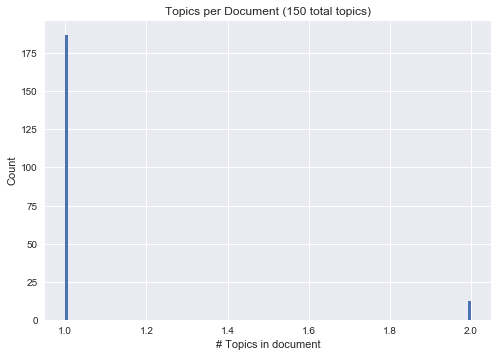

In [44]:
def plot_topics_per_doc(model, corpus, k):
    plt.style.use('seaborn')
    n_topics = []
    for doc in corpus_master:
        n_topics.append(len(lda.get_document_topics(doc)))
    n_topics
    
    plt.title('Topics per Document (' + str(k) + ' total topics)')
    plt.xlabel('# Topics in document')
    plt.ylabel('Count')
    plt.hist(n_topics, bins=k)
    plt.show()
    
plot_topics_per_doc(lda, corpus_master, k)

In [32]:
import operator

# returns DataFrame with topics and # of documents they appear in, sorted most to fewest
def get_topic_freq(lda, corpus):
    topic_counts = dict.fromkeys(range(k), 0)
    for doc in corpus:
        for topic in lda.get_document_topics(doc):
            topic_counts[topic[0]] += 1
    return pd.DataFrame(sorted(topic_counts.items(), key=operator.itemgetter(1), reverse=True), columns=['Topic', 'n_docs'])

# plot a sorted, horizontal bar chart of top topics
def plot_top_topics(lda, topic_freq, n):
    plt.style.use('seaborn')
    top = topic_freq[:n]
    if (n>25):
        plt.figure(figsize=(20, 22))
        plt.rcParams.update({'font.size': 40})
        plt.yticks(range(n), [[x[0] for x in lda.show_topic(t)] for t in top['Topic']], fontsize = 20)
    else:
        plt.yticks(range(n), [[x[0] for x in lda.show_topic(t)] for t in top['Topic']])
    plt.barh(range(n), top['n_docs'])
    
    plt.gca().invert_yaxis()
    plt.title('Top ' + str(n) +' topics')
    plt.xlabel('# documents containing topic')
    
    plt.show()

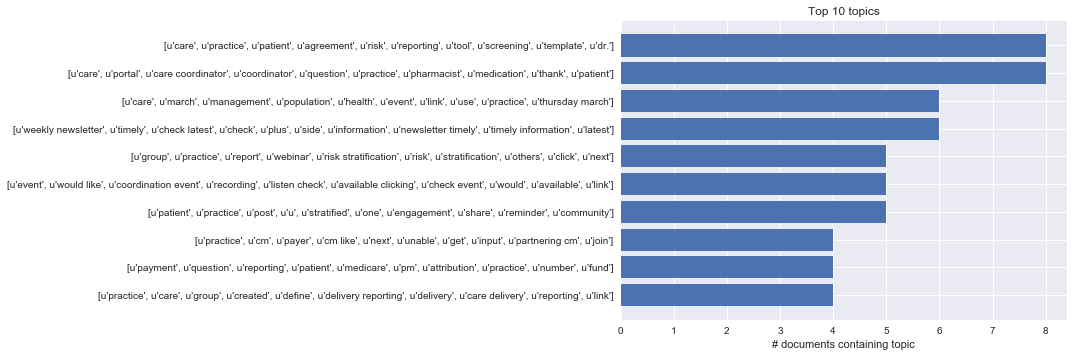

In [33]:
topic_freq = get_topic_freq(lda, corpus_master)
plot_top_topics(lda, topic_freq, 10)

In [45]:
def assign_topic_to_doc(lda, corpus, report):
    i= 0
    report['Topic'] = "NA"

    for doc in corpus:
        doc_topic = lda.get_document_topics(doc)[0][0]
        topic_list = []
        for x in lda.show_topic(doc_topic):
            topic_list.append(x[0])
        report['Topic'].iloc[i] = topic_list
        i += 1
    return report


In [46]:
topics_report = assign_topic_to_doc(lda, corpus_master, final_report)

In [47]:
topics_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type,tokens,Topic
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post,"[everyone, portal, access, everyone portal, po...","[portal, everyone, access, group, new group, n..."
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post,"[trying, figure, document/track, use, cmf, pay...","[cmf, help, know, required, code, use, additio..."
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post,"[appreciate, participation, care, management, ...","[webinar, slide post, others, download, video ..."
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post,"[group, created, within, connect, saw, post, t...","[patient, risk, practice, would, performance, ..."
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post,"[attention, practice, payer, region, currently...","[payer, cm, money, practice, payer region, usi..."


In [48]:
topics_report.to_excel('output.xlsx')